# Chapter 8 비지도 학습

## 8.1 비지도 학습이란
- 클러스터링 Clustering: 입력 데이터로부터 특성을 뽑아 유사 성질들을 군집화
- 오토인코더 Autoencoder: 새로운 데이터 생성
- 생성적 적대 신경망 GAN

## 8.2 K-평균 알고리즘
- 비지도 학습은 정답이 없어 클러스터링 종류에 따라 군집을 다르게 할 수 있기에 종류 선택과 하이퍼 파라미터 값을 잘 따져야 함
- 각 클러스터(그룹)의 평균을 기준으로 점들을 배치시키는 알고리즘. 이때, 특정 거리 함수를 통해 각 중심 Centroid 과 입력값의 거리를 측정하고 그 중 가장 가까운 그룹으로 할당

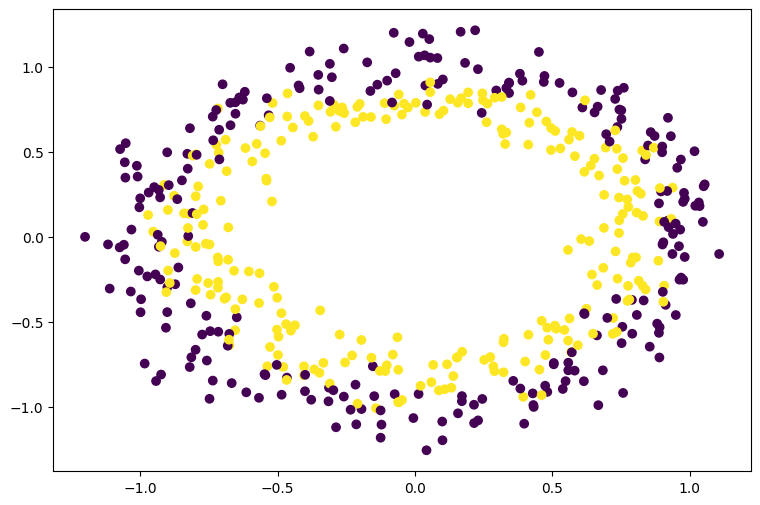

In [8]:
# 데이터  만들기

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

# 데이터 생성
x, y = make_circles(n_samples=500, noise=0.1) # 500개의 점 생성
plt.figure(figsize=(9,6))
plt.scatter(x[:,0],x[:,1],c=y)
plt.show()

In [9]:
# 텐서 데이터 변환하기

x = torch.FloatTensor(x)

In [10]:
# 거리 함수

def l2distance(a,b): # L2 거리 함수: 두 점 (중심과 각 점)들의 거리를 측정
  return torch.argmin(torch.sum((a-b)**2,dim=1),dim=0) # 각 점과 중심과의 거리를 계산하여 가장 거리가 가까운 점의 인덱스 반환

In [11]:
# K-평균 알고리즘에서는 클러스터의 수를 정해줘야 함

def kmeans(x,num_clusters=2,max_iteration=5): # 군집 수 기본값, 중심이 업데이트되는 횟수
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  x = x.to(device)
  # 초기 중심을 랜덤으로 할당. 중심 하나의 벡터 크기는 입력값의 피쳐 개수 x.size(1)와 같아야 함
  centroids = torch.rand(num_clusters,x.size(-1)).to(device)
  for update in range(max_iteration):
    y_assign = []
    for m in range(x.size(0)):
      # 이때 입력값 하나가 각 중심까지의 거리를 구해야 하므로 expand를 통해 입력값을 클러스터 개수만큼 복사하여 확장
      # 각 입력값마다 모든 중심과의 거리를 계산하여 가장 가까운 그룹으로 할당
      h = x[m].expand(num_clusters,-1)
      assign = l2distance(h,centroids)
      # 할당된 클러스터 정보 저장
      y_assign.append(assign.item())

    y_assign = np.array(y_assign)
    # update 횟수가 완료될 때까지 완성된 그룹들의 각 평균을 계산하여 중심 업데이트
    if update != max_iteration-1:
      for i in range(num_clusters):
        idx = np.where(y_assign == i)[0]
        centroids[i] = torch.mean(x[idx],dim=0)

  return y_assign, centroids

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

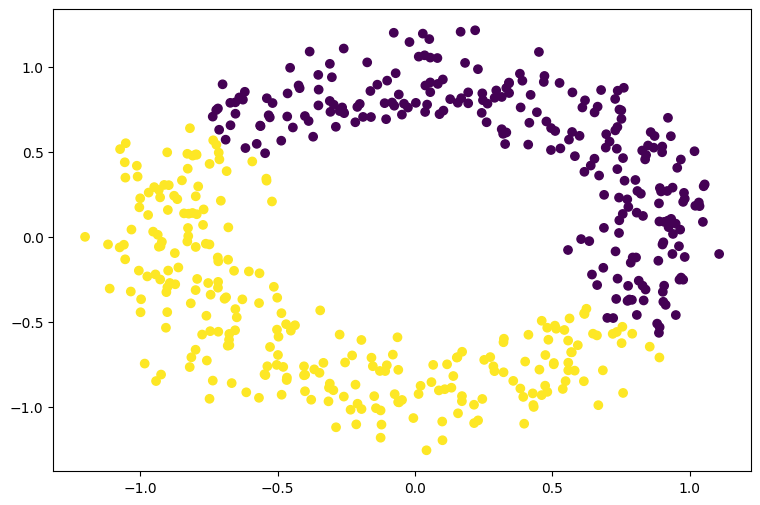

In [12]:
# 알고리즘 실행 및 그래프 그리기

# 데이터가 1차원인지 2차원인지 확인
if x.dim() == 1:
    x_2d = x.view(-1, 1)  # 1차원이면 2차원으로 변환
else:
    x_2d = x

# K-평균 알고리즘 실행
y_pred, centroids = kmeans(x_2d, 2)

# 그래프 그리기
plt.figure(figsize=(9, 6))
if x_2d.size(1) == 1:
    plt.scatter(x_2d, torch.zeros_like(x_2d), c=y_pred)
    plt.plot(centroids, torch.zeros_like(centroids), '*', markersize=30)
else:
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=y_pred)
    plt.plot(centroids[:, 0], centroids[:, 1], '*', markersize=30)

plt.show()

## 8.3 오토인코더
- 입력 데이터를 압축하는 Encoder 부분과 압축을 푸는 Decoder 부분으로 구성됨.
- 따라서 Encoder를 통해 차원 축소가 된 잠재 변수 Latent variable 를 가지고 별도 계산을 하거나, Decoder를 통해 입력값과 유사한 값을 생성할 수 있음
- 기본적으로 입력값 x와 출력값 x'를 이용하여 MSE를 정의하고 이를 기준으로 학습 진행

### 8.3.1 스택 오토인코더

In [2]:
# 라이브러리 불러오기

import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# GPU 연산 정의 및 MNIST 데이터 불러오기

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = torchvision.datasets.MNIST('./data/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 172365276.48it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 90399771.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30253507.89it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17558091.03it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# 모델 구축하기
# 기본 오토인코더 모델은 층을 여러 개 쌓았다고 해서 스택 오토인코더라고도 부름

class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        # MNIST 이미지 크기는 1x28x28. 따라서 일렬로 편 후 인코더 부분에 크기가 784(28x28) 벡터가 하나 들어옴
        nn.Linear(784, 128),
        # 층을 자유롭게 여러 개 쌓아 노드를 10개까지 줄임. 즉, 잠재 변수의 크기가 10으로 정의됨
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32, 10),
        nn.ReLU()
    )
    # 크기가 줄어든 잠재 변수 벡터를 디코더에 넣어 다시 크기를 늘려준다
    self.decoder = nn.Sequential(
        nn.Linear(10, 32),
        nn.ReLU(),
        nn.Linear(32, 128),
        nn.ReLU(),
        nn.Linear(128, 28*28),
        nn.Sigmoid() # 이미지 픽셀값은 0 이상 1 이하이므로, 범위를 정해서 수렴을 빨리 하도록 함
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [5]:
# 모델, 손실 함수, 최적화 기법 정의하기
# 우리의 목적은 입력 이미지와 유사한 출력 이미지를 얻는 것
# 따라서 입력 이미지와 출력 이미지의 L2 거리를 계산하는 MSE 손실 함수를 사용하고  최적화 방법은 Adam 사용

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [6]:
# 학습하기

for epoch in range(51):
  running_loss = 0.0
  for data in trainloader:
    inputs = data[0].to(device)
    optimizer.zero_grad()
    # 현재 오토인코더의 층은 합성곱 층이 아니고 일렬 노드로 구성된 nn.Linear
    outputs = model(inputs.view(-1,28*28))
    # 벡터 형태로 나온 출력값을 다시 정사각형 이미지로 변환하기 위해
    outputs = outputs.view(-1,1,28,28)
    loss = criterion(inputs, outputs)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  cost = running_loss / len(trainloader)
  print('[%d] loss:%.3f' %(epoch+1,cost))

[1] loss:0.083
[2] loss:0.057
[3] loss:0.049
[4] loss:0.044
[5] loss:0.041
[6] loss:0.037
[7] loss:0.034
[8] loss:0.032
[9] loss:0.030
[10] loss:0.029
[11] loss:0.028
[12] loss:0.028
[13] loss:0.027
[14] loss:0.027
[15] loss:0.026
[16] loss:0.026
[17] loss:0.026
[18] loss:0.025
[19] loss:0.025
[20] loss:0.025
[21] loss:0.025
[22] loss:0.024
[23] loss:0.024
[24] loss:0.024
[25] loss:0.024
[26] loss:0.024
[27] loss:0.024
[28] loss:0.023
[29] loss:0.023
[30] loss:0.023
[31] loss:0.023
[32] loss:0.023
[33] loss:0.023
[34] loss:0.023
[35] loss:0.023
[36] loss:0.022
[37] loss:0.022
[38] loss:0.022
[39] loss:0.022
[40] loss:0.022
[41] loss:0.022
[42] loss:0.022
[43] loss:0.022
[44] loss:0.022
[45] loss:0.022
[46] loss:0.022
[47] loss:0.022
[48] loss:0.021
[49] loss:0.021
[50] loss:0.021
[51] loss:0.021


### 8.3.2 디노이징 오토인코더
- 오토인코더의 기본적인 목적은 새로운 데이터를 만드는 것. 따라서 출력 데이터를 입력 데이터에 가까워지도록 학습한다면 기존의 데이터와 매우 유사하여 새로운 데이터를 만드는 의미가 무색해질 수 있음
- 따라서 입력값에 과적합되지 않도록 입력값에 노이즈를 주입시키거나 신경망에 드롭아웃을 적용하여 출력 데이터를 생성하고 출력 데이터와 노이즈가 없는 원래 입력 데이터를 가지고 손실 함수 계산
- 즉, 노이즈가 있는 이미지를 가지고 노이즈가 없는 이미지와 유사한 데이터를 만드는 구조이기에 Denoising autoencoder라 함

In [ ]:
for epoch in range(101):
  running_loss = 0.0
  for data in trainloader:
    inputs = data[0].to(device)
    optimizer.zero_grad()
    # 입력 이미지에 가우시안 노이즈 주입
    # 노이즈 텐서의 사이즈는 이미지 사이즈와 같아야 하며, 평균과 표준편차는 임의로 0,0.5 넣음
    dirty_inputs = inputs + torch.normal(0,0.5,size=inputs.size()).to(device)
    outputs = model(dirty_inputs.view(-1,28*28))
    outputs = outputs.view(-1,1,28,28)
    loss = criterion(inputs, outputs)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  cost = running_loss / len(trainloader)
  print('[%d] loss: %.3f' %(epoch+1,cost))

## 8.4 생성적 적대 신경망 GAN
- 진짜 같은 가짜 데이터를 만들어 내는 기술
- 가짜 이미지를 만드는 Generator와 진짜 이미지와 가짜 이미지를 구별하는 Discriminator로 구성됨 (0/1)
- 손실 함수는 이진 크로스 엔트로피 함수 형태로 정의 (반비례)
- 모델 변수에 대해 업데이터가 두 번 일어남
  - 생성자: 손실값이 최소가 되는 방향으로 모델 변수 업데이트하여 구별자가 구별을 잘 못 하도록 함
  - 구별자: 모델 변수를 손실 함수값이 커지는 방향으로 업데이트하여 구별을 잘 하도록 함

### 8.4.1 Vanilla GAN

In [1]:
# 라이브러리 불러오기

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid # 격자 형태 이미지
import imageio # gif 파일 생성
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 패션 아이템 데이터 불러오기

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
trainset = FashionMNIST(root='./data/', train=True, download= True,transform = transform)
trainloader = DataLoader(trainset, batch_size =100, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

100%|██████████| 26421880/26421880 [00:01<00:00, 15720992.78it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 257391.76it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4986666.06it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17611971.45it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
# 생성자 구축하기

class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    # 생성자는 잠재 변수로부터 784(28x28) 크기인 벡터 생성
    self.n_features = 128
    self.n_out = 784
    self.linear = nn.Sequential(
        # 기본 GAN에서는 nn.Linear을 이용하여 모델을 구축하며 활성 함수로는 nn.LeakyReLU 사용
        nn.Linear(self.n_features,256),
        nn.LeakyReLU(0.2), # 기울기 사라짐 방지를 위해 음수 구간의 양의 기울기를 주어 0.2 (y=0.2x)
        nn.Linear(256,512),
        nn.LeakyReLU(0.2),
        nn.Linear(512,1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024,self.n_out),
        nn.Tanh()
    )

  def forward(self,x):
    # 784 크기의 벡터를 크기가 28x28인 흑백 이미지로 변경
    x = self.linear(x)
    x = x.view(-1,1,28,28)
    return x

In [4]:
# 구별자 구축하기

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.n_in = 784 # 이미지를 일렬로 편 크기
    self.n_out = 1 # 출력값은 진위여부를 판단하기 위해 하나의 숫자로 정의
    self.linear = nn.Sequential(
      nn.Linear(self.n_in,1024),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(1024,512),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(512,256),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(256,self.n_out),
      nn.Sigmoid() # 출력값은 0과 1 사이의 값 출력되도록
    )

  def forward(self,x):
    x = x.view(-1,784) # 이미지를 벡터 형태로 변경하여 신경망에 대입
    x = self.linear(x)
    return x

In [5]:
# 모델 정의하기 (생성자, 구별자)

generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [6]:
# 손실 함수 및 최적화 기법 정의하기

g_optim = optim.Adam(generator.parameters(), lr=2e-4) # 생성자 변수 최적화를 위한 Adam
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4) # 구별자 변수 최적화를 위한 Adam
# 학습 동안 손실 함수값과 샘플 이미지 저장을 위한 빈 리스트
g_losses = []
d_losses = []
images = []
criterion = nn.BCELoss() # 손실 함수는 이진 크로스 엔트로피 함수 사용

In [7]:
# 잠재 변수 및 라벨 정의

# 기본적으로 크기가 128인 잠재 변수 n개를 무작위 생성
# 손실 함수에서 이미지의 진위 여부에 대한 계산을 하게 됨.
# 따라서 실제 이미지의 클래스를 사용하지 않고 진짜 데이터 라벨은 1, 생성자로부터 만들어진 이미지 라벨은 0이라 정의
def noise(n,n_features=128):
  data = torch.randn(n,n_features)
  return data.to(device)

# 1라벨
def label_ones(size):
  data = torch.ones(size,1)
  return data.to(device)

# 0라벨
def label_zeros(size):
  data = torch.zeros(size,1)
  return data.to(device)

In [9]:
# 구별자 학습 함수 정의하기

def train_discriminator(optimizer, real_data, fake_data): # 진짜 이미지, 가짜 이미지, 최적화 함수
  n = real_data.size(0) # 각 이미지 진위 라벨을 할당하기 위해 이미지 개수 확인
  optimizer.zero_grad()
  prediction_real = discriminator(real_data) # 진짜 이미지 판별
  d_loss = criterion(prediction_real, label_ones(n)) # 이미지 수만큼 1라벨을 넣어 손실 함수 계산
  prediction_fake = discriminator(fake_data) # 가짜 이미지 판별
  g_loss = criterion(prediction_fake, label_zeros(n)) # 0라벨
  loss = d_loss + g_loss
  loss.backward()
  optimizer.step()
  return loss.item()

In [11]:
# 생성자 학습 함수 정의하기

def train_generator(optimizer, fake_data): # 가짜 이미지 받음
  n = fake_data.size(0) # 이미지 개수 정하기
  optimizer.zero_grad
  prediction = discriminator(fake_data) # 가짜 이미지를 구별자에 넣어 판별
  # 생성자 입장에서는 구별자가 진짜 이미지라고 판단하도록 업데이트가 되어야 하므로 0라벨이 아닌 1라벨을 넣어 손실 함수 계산
  loss = criterion(prediction, label_ones(n))
  loss.backward()
  optimizer.step()
  return loss.item()

In [ ]:
# 모델 학습하기

test_noise = noise(64) # 검증을 위한 무작위 잠재 변수 64개 생성
l = len(trainloader) # 평균 손실값을 구하는데 사용하는 배치 수 저장
for epoch in range(151):
  # 각 에폭마다 손실값 초기화
  g_loss = 0.0
  d_loss = 0.0
  for data in trainloader:
    # 진짜 이미지를 받고 진짜 이미지의 개수를 정의
    imgs,_ = data
    n = len(imgs)
    # 진짜 이미지의 개수만큼 가짜 이미지를 생성
    fake_data = generator(noise(n)).detach() # detach()를 통해 불필요한 requires_grad 비활성화
    real_data = imgs.to(device)
    # 가지고 있는 이미지를 모두 구별자에 넣어 판별, 구별자 업데이트, 반환한 손실 함수값 누적
    d_loss += train_discriminator(d_optim, real_data, fake_data)
    # 생성자 업데이트, 반환한 손실 함수값 누적
    fake_data = generator(noise(n))
    g_loss += train_generator(g_optim, fake_data)

  # 검증을 위해 고정된 잠재 변수를 넣어 이미지를 생성하고 변화를 알아보기 위해 격자 형태의 이미지로 만들어 images 리스트에 저장
  img = generator(test_noise).detach().cpu()
  img = make_grid(img)
  images.append(img)
  # 손실 함수값 변화 저장
  g_losses.append(g_loss/l)
  d_losses.append(d_loss/l)
  # 에폭 10단위마다 손실값 출력
  if epoch % 10 == 0:
    print('Epoch {}: g_loss: {:.3f} d_loss: {:.3f}\r'.format(epoch, g_loss/l,d_loss/l))

Epoch 0: g_loss: 24.520 d_loss: 0.000
Epoch 10: g_loss: 27.821 d_loss: 0.000
Epoch 20: g_loss: 29.971 d_loss: 0.000
Epoch 30: g_loss: 99.969 d_loss: 0.000
Epoch 40: g_loss: 99.972 d_loss: 0.000
Epoch 50: g_loss: 99.923 d_loss: 0.000
Epoch 60: g_loss: 99.972 d_loss: 0.000
Epoch 70: g_loss: 99.973 d_loss: 0.000
Epoch 80: g_loss: 99.992 d_loss: 0.000
Epoch 90: g_loss: 99.992 d_loss: 0.000
Epoch 100: g_loss: 99.992 d_loss: 0.000
Epoch 110: g_loss: 99.990 d_loss: 0.000


In [13]:
# 모델 저장하기

torch.save(discriminator.state_dict(),'./models/fminist_disc.pth')
torch.save(generator.state_dict(),'./models/fmnist_gner.pth')

In [ ]:
# 검증 이미지 변화를 gif 파일로 저장하기

to_image = transforms.ToPILImage()
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('fashion_items.gif',imgs)

### 8.4.2 Deep Convolutional GAN(DCGAN)
- GAN 구조를 합성곱 층으로 구성한 모델
- 이미지 처리에 더 유리 (선명한 이미지)

## 8.5 이미지 스타일 변이
- 한 장의 스타일 이미지와 한 장의 내용 이미지를 가지고 새로운 스타일의 내용 이미지를 만드는 비지도 학습 방법
- 지금까지는 모델들을 최적화했다면, 스타일 변이는 결과 이미지를 최적화하는 작업 수행

In [2]:
# 라이브러리 불러오기

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models

In [3]:
# 모델 불러오기
# 이미지의 유의미한 특성을 추출하기 위해 사전 훈련된 모델 중 피쳐 추출 부분(합성곱 층) 불러옴

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 83.5MB/s]


In [13]:
# 내용 손실 함수 정의하기
# 업데이트를 하고자 하는 내용 이미지(input)의 피쳐맵과 원래의 내용 이미지(self.target)의 피쳐맵 손실을 MSE로 계산

class ContentLoss(nn.Module):
  def __init__(self,target,):
    super(ContentLoss,self).__init__()
    self.target = target.detach()

  def forward(self,input):
    self.loss = F.mse_loss(input,self.target)
    return input

In [5]:
# 스타일 손실 함수 정의하기
# 각 피쳐맵의 유사도를 비교하기 위해 피쳐맵 의 Gram matrix를 구한 결과 값 이용하여 MSE 손실 함수 계산

def gram_matrix(input):
  a,b,c,d = input.size() # 이미지 크기 저장
  features = input.view(a*b,c*d) # 크기가 cxd인 이미지를 일렬 벡터로 (배치 크기 a)x(채널 수 b)개만큼 만듦 => 2차원 텐서로
  G = torch.mm(features, features.t()) # features의 전치 텐서와 features를 행렬 곱 수행 (각 벡터들의 내적을 계산하여 유사도 표현)
  return G.div(a*b*c*d) # 전체 크기로 나누어 값 반환

In [6]:
class StyleLoss(nn.Module):
  def __init__(self,target_feature):
    super(StyleLoss,self).__init__()
    # 스타일 이미지(self.target)와 업데이트할 이미지(input)의 각 피쳐맵의 Gram_matrix를 각각 구함
    self.target = gram_matrix(target_feature).detach()

  def forward(self,input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G,self.target)
    return input

In [7]:
# 정규화 함수 정의하기

class Normalization(nn.Module):
  def __init__(self,mean,std):
    super(Normalization,self).__init__()
    self.mean = mean.view(-1,1,1) # 평균
    self.std = std.view(-1,1,1) # 표준편차

  # 정규화 진행
  def forward(self,img):
    return (img - self.mean) / self.std

In [9]:
# 모델 재정의하기
# 스타일 변환을 위해 모델 중간의 피쳐맵의 결과들을 활용해 손실 함수 계산

def get_style_model_and_losses(cnn, style_img, content_img):
  # 내용 손실 함수는 VGG19의 4번째 합성곱 층의 피쳐맵 사용하여 계산
  content_layers = ['conv_4']
  # 스타일 손실 함수는 1번째부터 5번째 합성곱 층의 피쳐맵 사용. 이때, 학습 시 각 층의 손실 함수들의 합으로 정의
  style_layers = ['conv_1','conv_2','conv_3','conv_4','conv_5']
  # 정규화에 필요한 평균과 표준편차 정의
  normalization_mean = torch.tensor([0.485,0.456,0.406]).to(device)
  normalization_std = torch.tensor([0.229,0.224,0.225]).to(device)
  normalization = Normalization(normalization_mean,normalization_std).to(device)
  content_losses = []
  style_losses = []
  # 모델 재정의 시작
  model = nn.Sequential(normalization)
  i = 0

  # 원래 모델 cnn의 층을 하나씩 불러옴
  for layer in cnn.children():
    # 만약 층이 합성곱층이면 i를 1씩 더함
    if isinstance(layer,nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer,nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer,nn.MaxPool2d):
      name = 'maxpool_{}'.format(i)
    elif isinstance(layer,nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else: # 이름이 없다면 error
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name,layer)
    if name in content_layers:
      target = model(content_img)
      content_loss = ContentLoss(target)
      model.add_module("content_loss_{}".format(i),content_loss)
      content_losses.append(content_loss)
    if name in style_layers:
      target_feature = model(style_img)
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i),style_loss)
      style_losses.append(style_loss)

  # 구성된 model을 역순으로 읽어 최종 손실 함수가 있는 위치 i를 파악
  for i in range(len(model) - 1,-1,-1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break
  # 최종 손실 함수가 있는 부분만 모델을 사용하기에 i번째까지 층을 잘라 그 뒤로 배제한 뒤 모델 정의
  model = model[:(i+1)]
  return model,style_losses,content_losses

In [16]:
# 결과 이미지 최적화하기

# 모델, 내용 이미지, 스타일 이미지, 학습 횟수, 손실 함수의 가중치들
def run_style_transfer(cnn, content_img, style_img, num_steps=300, style_weight=100000, content_weight=1):
  # 업데이트하고자 하는 이미지 input_img의 초깃값을 내용 이미지로 정하고 최적화를 위해 활성화
  input_img = content_img.clone().detach().requires_grad_(True)
  # 특정 층에 손실 함수가 들어 있는 모델을 만들고 손실 함수와 함께 정의
  model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img)
  # Limited-memory Broyden-Fletcher-Goldfarb-Shanno algorithm 최적화 기법을 사용함
  # 헤시안 행렬(2차 미분)을 계산하는 방법으로, closure()를 정의하여 1차 미분값 저장
  optimizer = optim.LBFGS([input_img]) # 모델이 아닌 입력 이미지 최적화
  iteration = [0]
  while iteration[0] <= num_steps:
    def closure():
      # clamp으로 이미지 값을 0 이상 1 이하에서 관리하도록 함
      input_img.data.clamp_(0,1)
      optimizer.zero_grad()
      model(input_img)
      # 가중치 적용
      style_score = 0
      content_score = 0
      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss
      loss = style_weight*style_score + content_weight*content_score
      loss.backward()
      iteration[0] += 1
      if iteration[0] % 50 == 0:
        print('iteration {}: Style Loss : {:4f} Content Loss : {:4f}'.format(
            iteration[0], style_score.item(), content_score.item()
        ))
      return style_score + content_score
    optimizer.step(closure)
  return input_img.data.clamp_(0,1)

In [11]:
# 예제 이미지 불러오기

def image_loader(img_path):
  loader = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])
  image = Image.open(img_path).convert('RGB') # 4채널 -> 3채널 RGB
  image = loader(image).unsqueeze(0) # 배치 사이즈 1을 추가해 4차원으로 이미지 만듦
  return image.to(device)
style_img = image_loader("./data/imgA.jpg")
content_img = image_loader("./data/imgB.jpg")

In [17]:
 output = run_style_transfer(cnn, content_img, style_img)

iteration 50: Style Loss : 0.000110 Content Loss : 20.776348
iteration 100: Style Loss : 0.000042 Content Loss : 17.115524
iteration 150: Style Loss : 0.000027 Content Loss : 15.454764
iteration 200: Style Loss : 0.000019 Content Loss : 14.700427
iteration 250: Style Loss : 0.000022 Content Loss : 14.406525
iteration 300: Style Loss : 0.000017 Content Loss : 14.433227


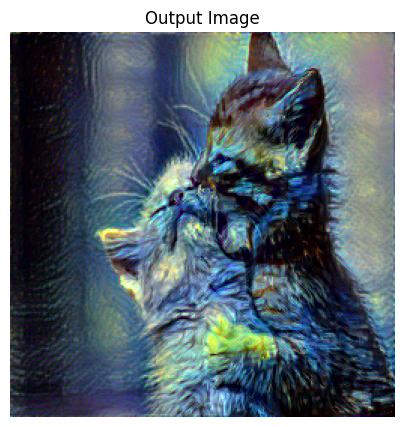

In [18]:
# 결과 이미지 보기

def imshow(image,title):
  unloader = transforms.ToPILImage()
  image = unloader(image.squeeze(0).cpu())
  plt.figure(figsize=(5,5))
  plt.imshow(image)
  plt.title(title)
  plt.axis("off")
  plt.show()
imshow(output,title='Output Image')